# Práctica de reconstrucción.  Parte I. Calibración de cámaras

Visión Computacional 2018-19 <br>
Practica 2. 29 de octubre de 2018

Este enunciado está en el archivo "PracticaCalib2018.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, que está implementado en OpenCV.
* Hacer uso de los resultados de la calibración en un sistema simple de realidad aumentada que proyecte un modelo 3D sintético sobre imágenes reales. Esta parte es opcional.
* Calibrar un par de cámaras y deducir información sobre la posición relativa de las mismas.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* El enunciado de esta práctica.
* Dos secuencias de imágenes tomadas con un par de cámaras (izquierda y derecha) en los directorios ``left`` y ``right``.
* Tres modelos tridimensionales: la tetera de Utah (teapot), el conejo de Stanford (bunny) y un cubo (cube).   
  La carga de un modelo en Python se realiza como si fuera un módulo. Por ejemplo: ``from models import bunny``.
El módulo cargado contiene dos variables:
  - ``bunny.vertices`` es una matriz $4 × N_v$ con las coordenadas homogéneas de los $N_v$ vértices del modelo (en este caso, el conejo de Stanford). Cada columna son las coordenadas de un vértice.
  - bunny.edges es una matriz 2×N e con los N e arcos del modelo. Cada columna contiene los índices de los dos vértices que une un arco.

## Condiciones

* La fecha límite de entrega será el martes 20 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as ppl
import math

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    """Load multiple images."""
    return [ppl.imread(image) for image in filenames]
# scipy.misc.imread() is deprecated, matplotlib.pyplot.imread() should be the same (checked for jpg)

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
files = glob.glob('./left/left_*.jpg')
sorted_files = sorted(files)
left_imgs = load_images(sorted_files)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) , esto es, 8 filas y 6 columnas. Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
pattern_size = (8,6)

In [5]:
corners = [cv2.findChessboardCorners(img,pattern_size) for img in left_imgs]

In [6]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
##corners2 = copy.deepcopy(corners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
##criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
##cornersRefined = ... TODO ...

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [7]:
imgs2 = copy.deepcopy(left_imgs)

for img, (success, corner) in zip(imgs2, corners):
    if success:
        cv2.drawChessboardCorners(img, pattern_size, corner, success)
# if success was false, the corners found would still be drawn

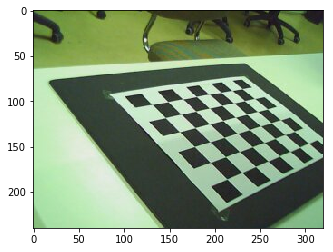

In [8]:
ppl.imshow(imgs2[0])

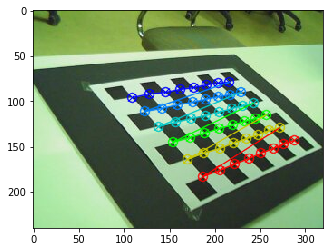

In [9]:
ppl.imshow(imgs2[1])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$ de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos por filas
y por columnas de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [10]:
def get_chessboard_points(chessboard_shape, dx, dy):
    y,x = chessboard_shape
    points = [[dx*i, dy*j, 0] for i in range(x) for j in range(y)]
    return np.array(points)

cb_points = get_chessboard_points(pattern_size, 30, 30)
print(cb_points)

[[  0   0   0]
 [  0  30   0]
 [  0  60   0]
 [  0  90   0]
 [  0 120   0]
 [  0 150   0]
 [  0 180   0]
 [  0 210   0]
 [ 30   0   0]
 [ 30  30   0]
 [ 30  60   0]
 [ 30  90   0]
 [ 30 120   0]
 [ 30 150   0]
 [ 30 180   0]
 [ 30 210   0]
 [ 60   0   0]
 [ 60  30   0]
 [ 60  60   0]
 [ 60  90   0]
 [ 60 120   0]
 [ 60 150   0]
 [ 60 180   0]
 [ 60 210   0]
 [ 90   0   0]
 [ 90  30   0]
 [ 90  60   0]
 [ 90  90   0]
 [ 90 120   0]
 [ 90 150   0]
 [ 90 180   0]
 [ 90 210   0]
 [120   0   0]
 [120  30   0]
 [120  60   0]
 [120  90   0]
 [120 120   0]
 [120 150   0]
 [120 180   0]
 [120 210   0]
 [150   0   0]
 [150  30   0]
 [150  60   0]
 [150  90   0]
 [150 120   0]
 [150 150   0]
 [150 180   0]
 [150 210   0]]


**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

Para ello usa la función calibrate que se distribuye con el material de la práctica.
Guarda el resultado de la calibración, matriz de intrínsecos y matrices de extrínsecos, con el comando
np.savez(‘calib_left’, intrinsic=intrinsic, extrinsic=extrinsic)

In [11]:
# Extract the list of valid images with all corners
valid_corners = [chess_corners for valid, chess_corners in corners if valid]

num_valid_images = len(valid_corners)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.repeat(cb_points[np.newaxis,...], num_valid_images, axis=0).astype('float32')
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.squeeze(np.stack(valid_corners, axis=0), axis=2)

# Calibrate for square pixels corners standard
img_size = left_imgs[0].shape[0:2]
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points,
                                            image_points, img_size, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:", dist_coeffs)
print("rms:", rms)

Corners standard intrinsics:
 [[420.10561639   0.         148.74766458]
 [  0.         420.10561639 126.97548974]
 [  0.           0.           1.        ]]
Corners standard dist_coefs: [[ 1.39266936e-02 -3.19035349e+00  5.20919353e-03 -6.50852609e-03
   1.89822222e+01]]
rms: 0.15324985266391153


In [13]:
def extr_matrix(rvec,tvec):
    extr_matrix = np.identity(4)
    extr_matrix[0:3,0:3],_ = cv2.Rodrigues(rvec)
    extr_matrix[0:3,3:] = tvec
    return extr_matrix

extrinsics = [extr_matrix(rvec,tvec) for rvec, tvec in zip(rvecs,tvecs)]

In [14]:
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región. Justifica esta solución.

Tenemos que calcular, a partir de la matriz de intrínsecos, el ángulo que forman las rectas que pasan por el centro óptico de la cámara y se proyectan en los puntos (10,10) y (59,59) respectivamente. Si M es la matriz de intrínsecos, esas rectas se obtienen para puntos de la imagen (u,v) de resolver la ecuación $(\lambda v,\lambda u,\lambda)^T = M*(x,y,z,1)^T$. Si omitimos la última columna de ceros de M y el 1, nos queda una ecuación equvalente donde la matriz $M'$ resultante es cuadrada y triangular superior, y por lo tanto invertible. Despejando nos queda $(x,y,z)=M'^{-1}*(\lambda v,\lambda u, \lambda)$, ecuación de la recta que buscamos. Cualquier solución a la ecuación será también un vector director de la recta, al pasar esta por el origen, y se puede obtener así dos vectores $w,k$ directores para las rectas que se proyectan en (10,10) y (59,59) y calcular el ángulo entre ellos usando la fórmula $cos(\theta) = \frac{w \cdot k}{|w||k|}$. A continuación definimos una función que implementa todo esto, y la aplicamos al ejemplo en cuestión para los parámetros intrínsecos calculados en los ejercicios anteriores

In [16]:
def diagonal_angle(upper_left, size, intrinsics): # intrinsics already as a square matrix, as calibrateCamera returns it
    i,j = upper_left
    a,b = size
    m = np.linalg.inv(intrinsics)
    v1 = np.array([j,i,1])
    v2 = np.array([j+b-1,i+a-1,1])
    w1 = m.dot(v1)
    w2 = m.dot(v2)
    angle_rad = math.acos(np.dot(w1,w2)/(np.linalg.norm(w1)*np.linalg.norm(w2)))
    return angle_rad*180/math.pi

In [17]:
diagonal_angle((10,10),(50,50), intrinsics)

8.416182284405032

## 2. Realidad aumentada (opcional)

El término *realidad aumentada* hace referencia al conjunto de técnicas que permiten representar información sintética no existente en el mundo real sobre imágenes reales. En nuestro caso, la información
sintética son modelos tridimensionales. Los siguientes ejercicios proponen una serie de pasos para implementar un
pequeño sistema de realidad aumentada, para lo cual serán necesarios los parámetros obtenidos durante la calibración.

**Ejercicio 6.** Implementa la función``m = proj(K, T, verts)`` que, dada la matriz de intrínsecos K (dimensión 3x3), extrínsecos T (dimensión 3 x 4) y una matriz de vértices expresados en coordenadas homogéneas ``verts``, calcule la proyección de los vértices 3D a puntos 2D de la imagen. Las coordenadas 2D resultantes deben ser homogéneas.
Es decir, este ejercicio consiste en implementar la ecuación de proyección vista en clase.

In [130]:
def proj(K, T, verts):
    result = []
    mix_mat = np.dot(K, T)
    for v in verts:
        result.append(np.dot(mix_mat, v))
    
    return np.array(result)

**Ejercicio 7.** Implementa una función ``plothom(points)`` que dibuje un conjunto de puntos 2D de entrada expresados en coordenadas homogéneas.

In [131]:
def plothom(points):
    points_t = points.transpose()
    points_t[0] = points_t[0]/points_t[2]
    points_t[1] = points_t[1]/points_t[2]
    
    affine_points = points_t[0:2].transpose()
    
    ppl.plot(points_t[0], points_t[1], '.')
    ppl.show()

**Ejercicio 8.** Usa las funciones implementadas en los ejercicios anteriores para proyectar un modelo sobre las imágenes de la secuencia. Para ello, modifica la función ``play_ar``, que se distribuye con la práctica, completando las partes marcadas con TODO:

1. Proyecta los vértices del modelo con ``proj`` usando los intrínsecos y los extrínsecos de la imagen que corresponda.
2. Dibuja los vértices proyectados o los arcos correspondientes con ``plothom``.

Prueba la función ``play_ar`` una vez terminada.

In [132]:
# read bunny model
from models import bunny

In [140]:
def play_ar(intrinsics, rvecs, tvecs, imgs, vertices):
    
    fig = ppl.gcf()
    
    for rv,tv,img in zip(rvecs, tvecs, imgs):
        fig.clf()
        # ppl.figure()
        
        # Create rotation matrix from rotation vector rv, use cv2.Rodrigues()
        rm = cv2.Rodrigues(rv)
        
        # Create 3 x 4 extrinsics
        
        T = np.identity(4)
        T[0:3,0:3],_ = rm
        T[0:3,3:] = tv
        
        # Project the model with proj.
        v2d = proj(intrinsics, T, vertices)

        # TODO: Draw the model with plothom
        plothom(v2d)
        
        # Plot the image.
        ppl.imshow(img)
        # ppl.draw()
        ppl.show()
        ppl.pause(0.3)

In [142]:
# play only images with detected corners
# valid_imgs = ... TODO ...

intrinsics_hom = np.zeros((3,4))
intrinsics_hom[:,:3] = intrinsics
intrinsics_hom

array([[420.10561639,   0.        , 148.74766458,   0.        ],
       [  0.        , 420.10561639, 126.97548974,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

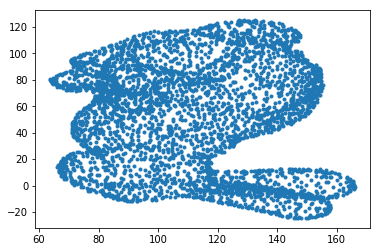

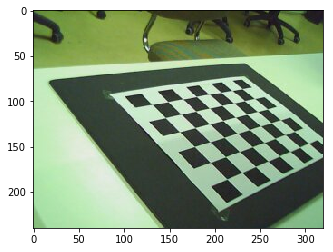

In [139]:
play_ar(intrinsics2, rvecs[0:1], tvecs[0:1], left_imgs[0:1], bunny.vertices.transpose())

**Ejercicio 9.** Transforma el modelo anterior para que se represente en
el centro de la plantilla de calibración y rotado 90 grados sobre el eje vertical del modelo. 
Ejecuta la función ``play_ar``con el nuevo modelo.

In [ ]:
new_vertices = ... TODO ...

play_ar(intrinsics, rvecs, tvecs, valid_imgs, new_vertices)

## 3. Par de cámaras

**Ejercicio 10.** Siguiendo el procedimiento de la primera parte
de la práctica, calibra la cámara derecha usando la secuencia
de imágenes del directorio ``right``.

In [16]:
files_r = glob.glob('./right/right_*.jpg')
sorted_files_r = sorted(files_r)
right_imgs = load_images(sorted_files_r)

corners_r = [cv2.findChessboardCorners(img,pattern_size) for img in right_imgs]

# Extract the list of valid images with all corners
valid_corners_r = [chess_corners for valid, chess_corners in corners_r if valid]

num_valid_images_r = len(valid_corners_r)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points_r = np.repeat(cb_points[np.newaxis,...], num_valid_images_r, axis=0).astype('float32')
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points_r = np.squeeze(np.stack(valid_corners_r, axis=0), axis=2)

# Calibrate for square pixels corners standard
rms_r, intrinsics_r, dist_coeffs_r, rvecs_r, tvecs_r = cv2.calibrateCamera(object_points_r,
                                            image_points_r, img_size, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

extrinsics_r = []

for rvec, tvec in zip(rvecs_r,tvecs_r):
    extr_matrix = np.identity(4)
    extr_matrix[0:3,0:3],_ = cv2.Rodrigues(rvec)
    extr_matrix[0:3,3:] = tvec
    extrinsics_r.append(extr_matrix)

np.savez('calib_right', intrinsic=intrinsics_r, extrinsic=extrinsics_r)

print("Corners standard intrinsics:\n",intrinsics_r)
print("Corners standerd dist_coefs:", dist_coeffs_r)
print("rms standard:", rms_r)

Corners standard intrinsics:
 [[434.57908591   0.         144.28575634]
 [  0.         434.57908591 132.65602226]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-0.13458078 -0.09622313  0.00683031 -0.00876898  0.92710878]]
rms standard: 0.20650058494191362


**Ejercicio 11.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras?

Sugerencia: Utiliza los extrínsecos del primer par de imágenes el que simultáneamente se vean todos los puntos de la plantilla.


Se entiende por el enunciado que las dos cámaras tienen siempre la misma posición relativa. Se entiende también que el enunciado se refiere a la distancia entre los centros ópticos de las dos cámaras. Si es así, dada un par de imágenes para las que se hayan detectado todas las esquinas para ambas cámaras y para las que por lo tanto se hayan calculado los extrínsecos, los vectores de traslación calculados indicarán la posición de cada cámera en la escena. La distancia las dos cámaras será la distancia entre los dos vectores de traslación, que ya estará expresada en milímetros ya que esta la unidad que hemos usado al dar las coordenadas de las esquinas.

A continuación mostramos esa distancia para cada par de imaǵenes posible. En teoría esa distancia debería ser constante, pero por supuesto la calibración no es exacta y y habrá algunas diferencias mínimas entre ellas.

In [17]:
index_l = -1
index_r = -1
for i in range(len(left_imgs)):
    valid_l,_ = corners[i]
    valid_r,_ = corners_r[i]
    if valid_l:
        index_l += 1
    if valid_r:
        index_r += 1
    if valid_l and valid_r:
        tvec_l = tvecs[index_l]
        tvec_r = tvecs_r[index_r]
        dist = np.linalg.norm(tvec_l-tvec_r)
        print(dist)

67.70967506447961
67.5658298209293
66.75691452199935
67.426343269849
66.93056352535874
66.83128823152164
67.55692109040459
67.61747293010221
67.71822145378118
66.98054736965962
68.260198687362
67.98459321032075
68.45656245689295
67.70868931617369
68.1667427705779
67.69350925804869
66.83129499488092
